In [1]:
# making the imports
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from functools import reduce
import numpy as np
from itertools import permutations, product
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
def beautify_plot(ttl, xl, yl, lg=True):
    '''
    Overrides the default title, xlabel, ylabel and legends
    '''
    plt.title(ttl)
    plt.xlabel(xl)
    plt.ylabel(yl);
    if lg:
        plt.legend();
        
base_loc = '/kaggle/input/restaurant-data-with-consumer-ratings/'

In [3]:
df_master_train = [pd.read_csv(base_loc+'rating_final.csv')] # read the data
df_master_test = [] # prepare the list to reduce the compiled profiling data
imputation_rules = {} # store rules for imputation

df_master_train[0].head() # get the head

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [4]:
df_master_train[0].placeID.nunique(), df_master_train[0].userID.nunique() # get the unique users and restaurants

(130, 138)

In [5]:
def get_info(df_temp, df_type):
    '''
    Function to get the customized details of a dataframe.
    '''
    print(f'The shape is :: {df_temp.shape}\n\nThe # duplicates :: {df_temp.duplicated().sum()}')
    print(f'\nThe # unique per column ::\n{df_temp.nunique()}')
    print(f'\nThe # NaNs per column ::\n{df_temp.isna().sum()}')
    if df_type=='chef':
        print(f'\nThe % Primary Key common in ratings and this df :: {pd.merge(df_temp, df_master_train[0]).placeID.nunique()/130*100:.2f}%')
    if df_type=='user':
        print(f'\nThe % Primary Key common in ratings and this df :: {pd.merge(df_temp, df_master_train[0]).userID.nunique()/138*100:.2f}%')

In [6]:
def process_categorical(values):
    '''
    Cleans and normalize categorical variable that has text
    '''
    return [i.strip().lower().replace(' ','_',).replace('-','_') for i in values]

We see that we have need to predict the `rating`. Now this is very obvious that all the restaurants will not be there in the ratings dataframe. Again, ideally all the customers should be.

So, let's first try to see how the restaurant details fit in for the ratings dataset.
 
`chef*` datasets are for the restaurants. Let's try to see what they have one by one and make them compatible for preparation of the final dataset.

### 1.1 chefmozaccepts

In [7]:
df1 = pd.read_csv(base_loc+'chefmozaccepts.csv') # read and get info on the data
get_info(df1, 'chef')

The shape is :: (1314, 2)

The # duplicates :: 0

The # unique per column ::
placeID     615
Rpayment     12
dtype: int64

The # NaNs per column ::
placeID     0
Rpayment    0
dtype: int64

The % Primary Key common in ratings and this df :: 87.69%


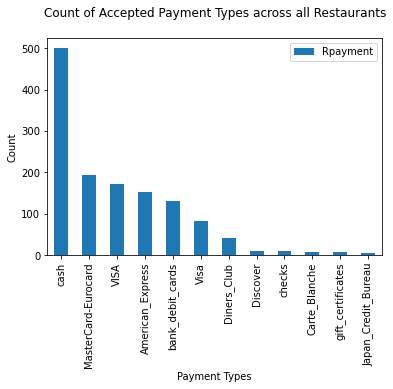

In [8]:
# plot the Count of Accepted Payment Types across all Restaurants
df1.Rpayment.value_counts().plot(kind='bar')
beautify_plot('Count of Accepted Payment Types across all Restaurants\n', 'Payment Types', 'Count')

A cool observation is that most of the places accepts cash. One more thing to notice is that 'VISA' and 'visa' are different values and it seems that it may be just an error. So, we process the categorical field.

In [9]:
df1['Rpayment'] = process_categorical(df1.Rpayment) # clean the Rpayment column

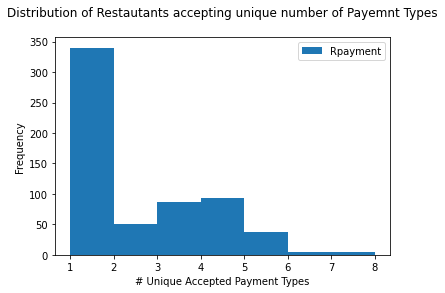

In [10]:
# plot the Distribution of Restautants accepting unique number of Payemnt Types
df1.groupby('placeID').count().sort_values('Rpayment').plot(kind='hist', bins=7);
beautify_plot('Distribution of Restautants accepting unique number of Payemnt Types\n', 
              '# Unique Accepted Payment Types', 
              'Frequency')

A quick glance reveals that most of the places accepts a single mode of payment.

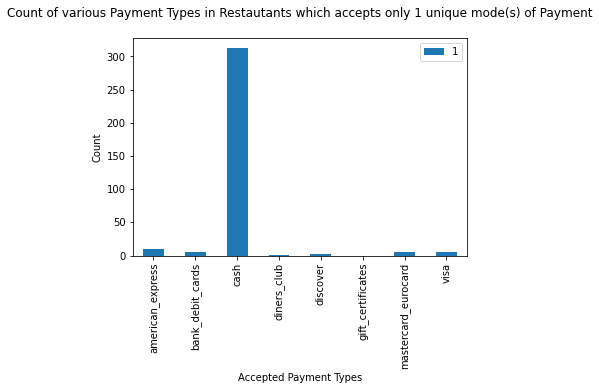

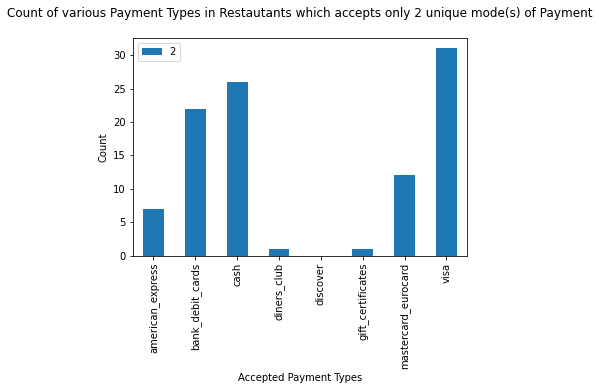

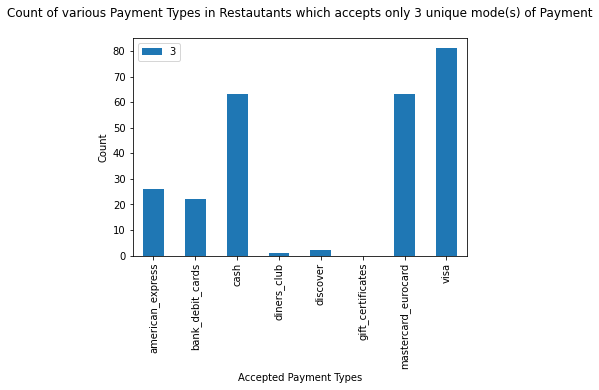

In [11]:
# plot the Count of various Payment Types in Restautants which accepts different unique mode(s) of Payment
df11 = df1.groupby('placeID').count().reset_index()
df11.columns = ['placeID', 'count']
df12 = df1.merge(df11).query('count<4').groupby('count').Rpayment.value_counts().unstack()
for i in range(0,df12.shape[0]):
    plt.subplots(1)
    df12.iloc[i].plot.bar()
    beautify_plot(f'Count of various Payment Types in Restautants which accepts only {i+1} unique mode(s) of Payment\n', 
                  'Accepted Payment Types', 
                  'Count')

We see the observation for those stores which accepts 1,2 and 3 mode of payments.
* We see that those most of the stores who accepts only 1 mode of payment, accepts cash.
* We see that those most of the stores who accepts only 2 modes of payment, accepts mostly visa, cash and debit cards.
* We see that those most of the stores who accepts only 3 mode of payment, accepts mostly visa, mastercards and less cash and lesser debit cards.

This may reveal a pattern that those stores which accept single mode of payments, does attract people with `low budgets` and those with more attracts people with `high or medium` budget.

We see that after the merge, there will be some restaurants who will have NaNs for the card types. We can impute them with `0`s. 

Also we see that are around 12 levels. So, we can conclude that we can accept them for the master data after One Hot Encoding.

In [12]:
df1_final = pd.get_dummies(df1).groupby('placeID').sum().reset_index() # one hot encode the features

# add the dataframe to the training and testing list
df_master_train.append(df1_final)
df_master_test.append(df1_final)

# store the imputation rules
imputation_rules.update({i:{'fillna': 0} for i in df1_final.columns[1:]})

In [13]:
df2 = pd.read_csv(base_loc+'chefmozcuisine.csv') # read and get info on the data
get_info(df2, 'chef')

The shape is :: (916, 2)

The # duplicates :: 0

The # unique per column ::
placeID     769
Rcuisine     59
dtype: int64

The # NaNs per column ::
placeID     0
Rcuisine    0
dtype: int64

The % Primary Key common in ratings and this df :: 73.08%


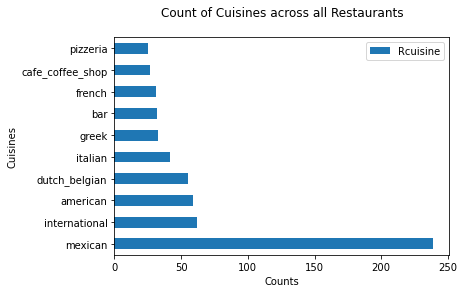

In [14]:
# plot the Count of Cuisines across all Restaurants
df2['Rcuisine'] = process_categorical(df2.Rcuisine)
cusines = df2.Rcuisine.value_counts()[:10] # get the top 10 cusines
cusines.plot.barh()
beautify_plot('Count of Cuisines across all Restaurants\n', 'Counts', 'Cuisines');

In [15]:
# bin the cuisines which are not in top 10 as others
df2['Rcuisine'] = df2.Rcuisine.replace([i for i in df2.Rcuisine.unique() if i not in cusines], 'others')

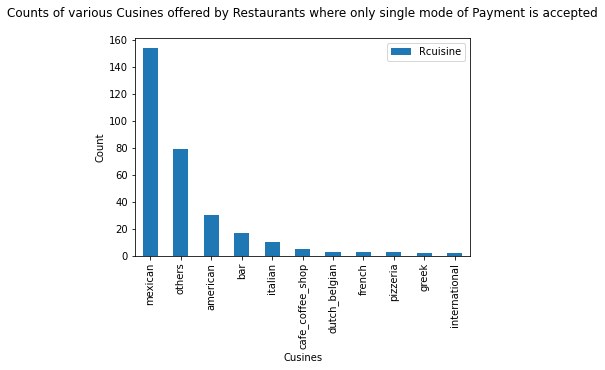

In [16]:
# plot the Counts of various Cusines offered by Restaurants where only single mode of Payment is accepted
df1.groupby('placeID').count().query('Rpayment==1').reset_index().merge(df2).Rcuisine.value_counts().plot.bar()
beautify_plot('Counts of various Cusines offered by Restaurants where only single mode of Payment is accepted\n',
              'Cusines', 'Count');

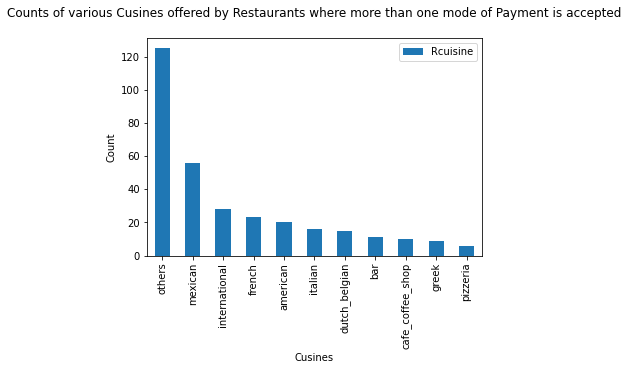

In [17]:
# plot the Counts of various Cusines offered by Restaurants where more than one mode of Payment is accepted
df1.groupby('placeID').count().query('Rpayment>1').reset_index().merge(df2).Rcuisine.value_counts().plot.bar()
beautify_plot('Counts of various Cusines offered by Restaurants where more than one mode of Payment is accepted\n',
              'Cusines', 'Count');

We do get quite an interesting pattern here. Previously we saw that **single mode of payments has predominant mode of payment as cash** and again, we see that those restaurants offer mostly **Mexican, American Cuisines and Bars**.

Also, for two or more mode of payments, there are **cards involved** and as per the distribution of the cuisines, we see that apart from Mexican and American (which can be burger joints), we can see more delicate **European cuisines like International, French, Italian etc**.

Once we have processed this dataframe, we will account for the NaNs after the join by imputing `1 in others` and `0 in rest of the cuisines`.  

In [18]:
df2_final = pd.get_dummies(df2).groupby('placeID').sum().reset_index() # one hot encode the features

# add the dataframe to the training and testing list
df_master_train.append(df2_final)
df_master_test.append(df2_final)

# store the imputation rules
imputation_rules.update({i: {'fillna': 1} if i=='Rcuisine_others' else {'fillna':0} for i in df2_final.columns[1:]})

### 1.3 chefmozhours4

In [19]:
df3 = pd.read_csv(base_loc+'chefmozhours4.csv') # read and get info on the data
get_info(df3, 'chef')

df3.head()

The shape is :: (2339, 3)

The # duplicates :: 271

The # unique per column ::
placeID    694
hours      273
days         3
dtype: int64

The # NaNs per column ::
placeID    0
hours      0
days       0
dtype: int64

The % Primary Key common in ratings and this df :: 98.46%


,placeID,hours,days
0,135111,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
1,135111,00:00-23:30;,Sat;
2,135111,00:00-23:30;,Sun;
3,135110,08:00-19:00;,Mon;Tue;Wed;Thu;Fri;
4,135110,00:00-00:00;,Sat;


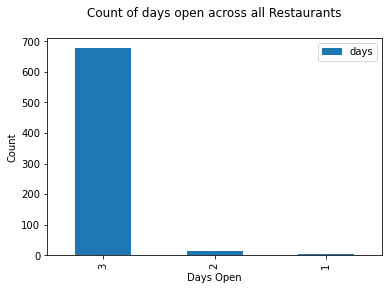

In [20]:
# plot the Count of days open across all Restaurants
df3.groupby('placeID').agg({'days': pd.Series.nunique}).days.value_counts().plot.bar();
beautify_plot('Count of days open across all Restaurants\n', 'Days Open', 'Count');

The data ideally should have `n*3 rows`, i.e the opening and closing hours for each place for Weekdays, Saturdays and Sundays. However we have some as 1 and 2 also. That means, if the shop is not open in either of the weekdays, sat or sun, it does not have a record.


We encounter a number of observations here.
* Duplicates are present
* The hours column has 273 unique values

We propose to do the following for the processing.

* Convert the hours column to number of actual numerical hours. If the hours come as 0, we say the shop is open for 24 hours. This is based on the previous observation of the distribution of days.
* Remove the duplicates on place and days (cannot have 2 records with different opening and closing timings for the same day)
* Do a pivot on the days and account the dataset for inclusion in the master file. Do a fillna of `0` for days in which it was not open.

The rule for imputation when creating the master will be impute by mode.

In [21]:
df3 = pd.read_csv(base_loc+'chefmozhours4.csv')
# feature engineer the actual hours
df3['hrs'] = df3.hours.apply(lambda x: np.ptp([int(j[:2]) for i in x.split(';') for j in i.split('-') if j]))
df3 = df3.replace(0, 24) # replace 0 (came as diff) with 24 for shops which are open round the clock

df3.drop_duplicates(subset=['placeID', 'days'], inplace=True)

# one hot encode the features
df3 = df3.pivot(index='placeID', columns='days', values='hrs')\
       .reset_index().rename_axis(None, axis=1)\
       .fillna(0).astype(int) # replace 0 for shops which are not open on days (after pivot)

# add the dataframe to the training and testing list
df3.columns = ['placeID', 'mon_tue_wed_thu_fri', 'sat', 'sun']
df_master_train.append(df3)
df_master_test.append(df3)

# store the imputation rules
imputation_rules.update({i: 'mode' for i in df3.columns[1:]})

### 1.4 chefmozparking

In [22]:
df4 = pd.read_csv(base_loc+'chefmozparking.csv') # read and get info on the data
get_info(df4, 'chef')

The shape is :: (702, 2)

The # duplicates :: 0

The # unique per column ::
placeID        675
parking_lot      7
dtype: int64

The # NaNs per column ::
placeID        0
parking_lot    0
dtype: int64

The % Primary Key common in ratings and this df :: 100.00%


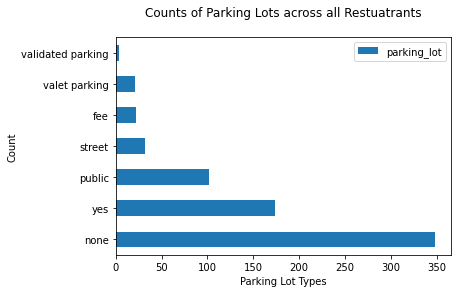

In [23]:
# plot the Counts of Parking Lots across all Restuatrants
df4.parking_lot.value_counts().plot.barh();
beautify_plot('Counts of Parking Lots across all Restuatrants\n', 'Parking Lot Types', 'Count');

The above data looks fine and is incorporated. We will create the rule for imputation with mode for any NaNs.

In [24]:
df4_final = pd.get_dummies(df4).groupby('placeID').sum().reset_index() # one hot encode the features

# add the dataframe to the training and testing list
df_master_train.append(df4_final)
df_master_test.append(df4_final)

# store the imputation rules
imputation_rules.update({i: 'mode' for i in df4_final.columns[1:]})

### 1.5 usercuisine

In [25]:
df5 = pd.read_csv(base_loc+'usercuisine.csv') # read and get info on the data
get_info(df5, 'user')

The shape is :: (330, 2)

The # duplicates :: 0

The # unique per column ::
userID      138
Rcuisine    103
dtype: int64

The # NaNs per column ::
userID      0
Rcuisine    0
dtype: int64

The % Primary Key common in ratings and this df :: 100.00%


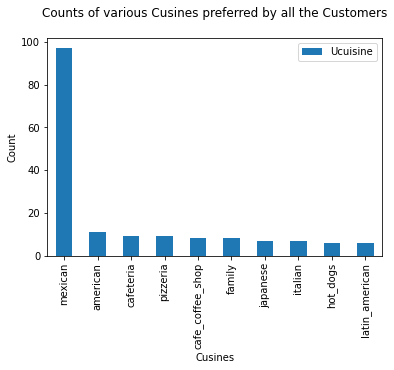

In [26]:
# plot the Counts of various Cusines preferred by all the Customers
df5['Ucuisine'] = process_categorical(df5.Rcuisine) # get the top 10 cusines
df5.Ucuisine.value_counts()[:10].plot.bar();
beautify_plot('Counts of various Cusines preferred by all the Customers\n', 'Cusines', 'Count');

We again need to bin the less popular ones in `others`.

Again we create the rule of replacing NaNs with others as 1 for User cuisines.

In [27]:
# bin the cuisines which are not in top 10 as others
df5['Ucuisine'] = df5.Ucuisine.replace([i for i in df5.Ucuisine.unique() if i not in cusines], 'others')
# one hot encode the features
df5_final = pd.concat([df5[['userID']], pd.get_dummies(df5.Ucuisine, prefix='Ucuisine')], axis=1)\
              .groupby('userID').sum().reset_index()

# add the dataframe to the training and testing list
df_master_train.append(df5_final)
df_master_test.append(df5_final)

# store the imputation rules
imputation_rules.update({i: {'fillna': 1} if i=='Ucuisine_others' else {'fillna':0} for i in df5_final.columns[1:]})

### 1.6 userpayment

In [28]:
df6 = pd.read_csv(base_loc+'userpayment.csv') # read and get info on the data
df6['Upayment'] = process_categorical(df6.Upayment)
get_info(df6, 'user')

The shape is :: (177, 2)

The # duplicates :: 0

The # unique per column ::
userID      133
Upayment      5
dtype: int64

The # NaNs per column ::
userID      0
Upayment    0
dtype: int64

The % Primary Key common in ratings and this df :: 96.38%


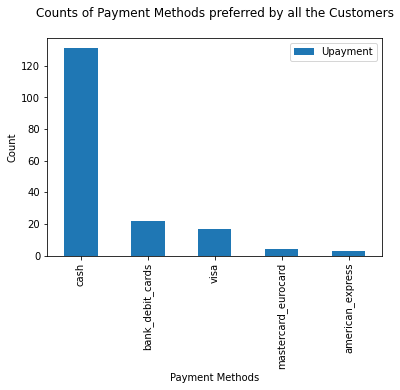

In [29]:
# plot the Counts of Payment Methods preferred by all the Customers
df6.Upayment.value_counts().plot(kind='bar');
beautify_plot('Counts of Payment Methods preferred by all the Customers\n', 'Payment Methods', 'Count');

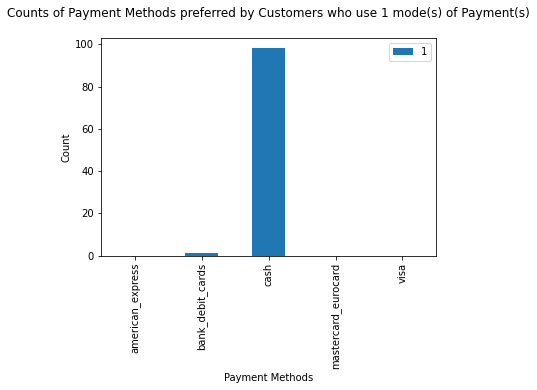

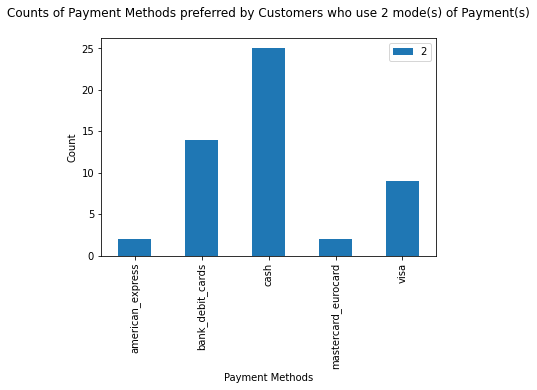

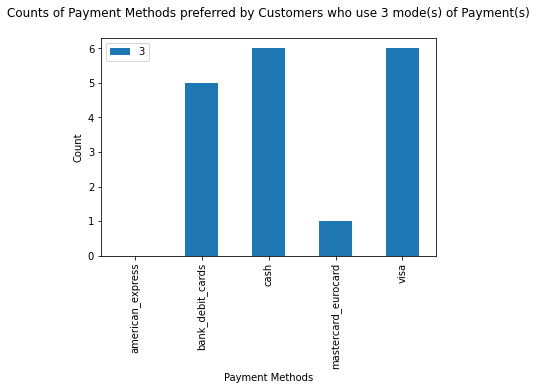

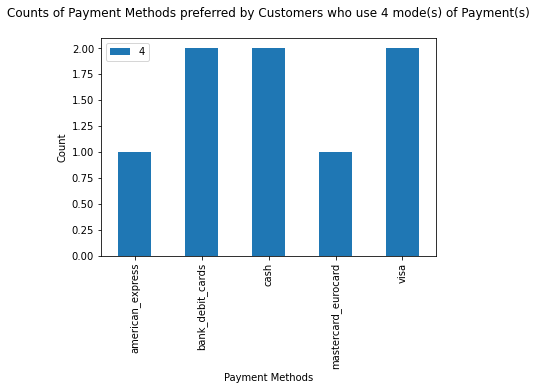

In [30]:
# plot the Counts of Payment Methods preferred by Customers who use various mode(s) of Payment(s)
df61 = df6.groupby('userID').count().reset_index()
df61.columns = ['userID', 'count']
df62 = df6.merge(df61).groupby('count').Upayment.value_counts().unstack()
for i in range(0,df62.shape[0]):
    plt.subplots(1)
    df62.iloc[i].plot.bar()
    beautify_plot(f'Counts of Payment Methods preferred by Customers who use {i+1} mode(s) of Payment(s)\n', 'Payment Methods', 'Count');

* The distribution that we see here is that the Users who like to pay via a single mode, it is always `cash`.
* For the others, they almost equally like to pay via cash, and cards.

For the customer who don't have this data, the imputation will happen by adding `1` to cash.

In [31]:
df6_final = pd.concat([df6[['userID']], pd.get_dummies(df6.Upayment, prefix='Upayment')], axis=1)\
              .groupby('userID').sum().reset_index() # one hot encode the features

# add the dataframe to the training and testing list
df_master_train.append(df6_final)
df_master_test.append(df6_final)

# store the imputation rules
imputation_rules.update({i:{'fillna': 1} if i=='Upayment_cash' else {'fillna': 0} for i in df6_final.columns[1:]})

### 1.7 userprofile

In [32]:
df7 = pd.read_csv(base_loc+'userprofile.csv') # read and get info on the data
get_info(df7, 'user')

The shape is :: (138, 19)

The # duplicates :: 0

The # unique per column ::
userID              138
latitude            128
longitude           126
smoker                3
drink_level           3
dress_preference      5
ambience              4
transport             4
marital_status        4
hijos                 4
birth_year           21
interest              5
personality           4
religion              5
activity              5
color                 8
weight               49
budget                4
height               38
dtype: int64

The # NaNs per column ::
userID              0
latitude            0
longitude           0
smoker              0
drink_level         0
dress_preference    0
ambience            0
transport           0
marital_status      0
hijos               0
birth_year          0
interest            0
personality         0
religion            0
activity            0
color               0
weight              0
budget              0
height              0
dtype: int

In [33]:
df7['age'] = (2020-df7.birth_year) # get the age

# get rid of some of the useless columns
to_drop = ['latitude', 'longitude', 'height', 'birth_year']
df7 = df7.drop(to_drop, axis=1)

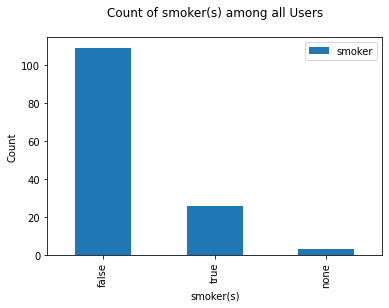

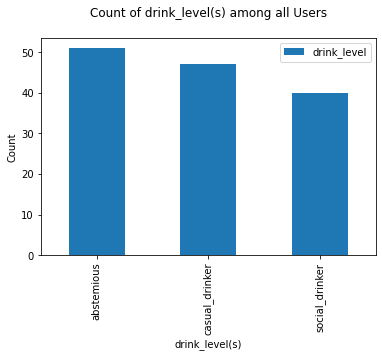

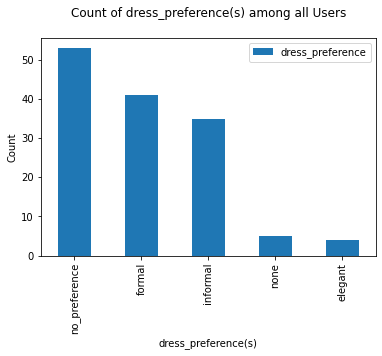

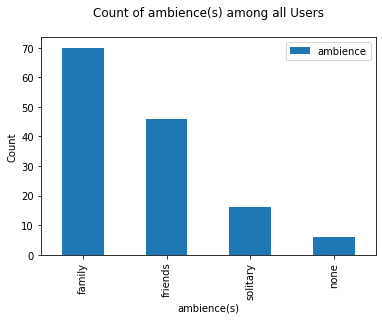

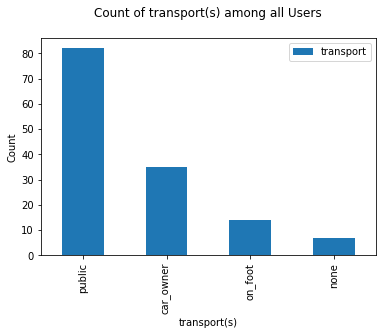

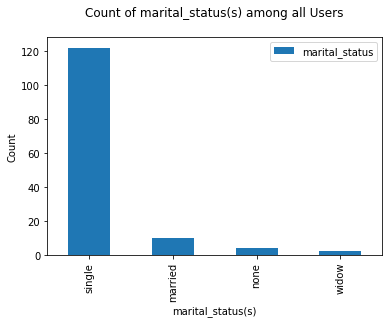

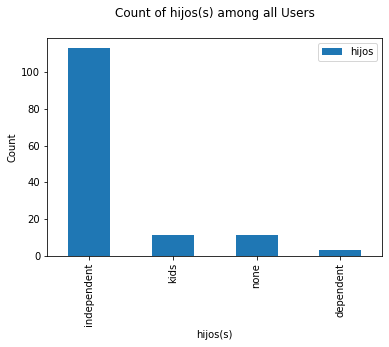

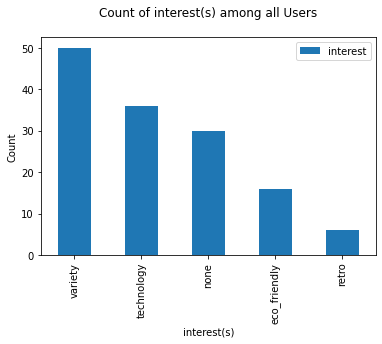

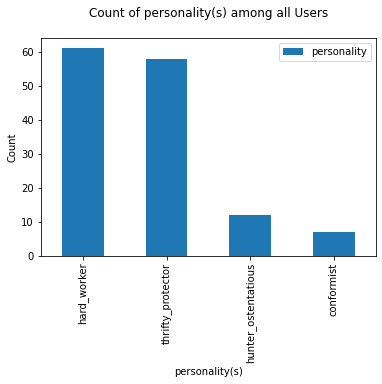

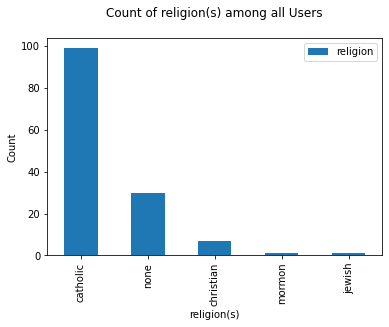

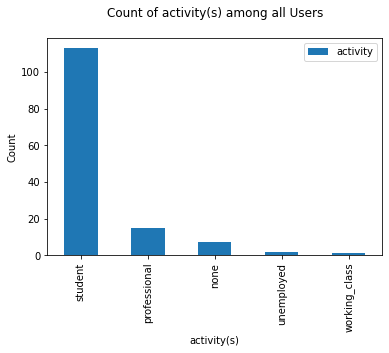

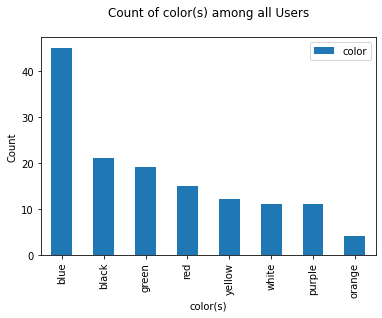

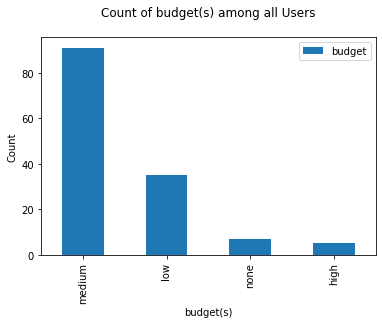

In [34]:
# Count of all the categorical variables
df7 = df7.replace('?', 'none') # replace the ? with none
for i in list(df7.select_dtypes('object').columns)[1:]:
    df7[i] = process_categorical(df7[i])
    plt.subplots(1)
    df7[i].value_counts().plot.bar()
    beautify_plot(f'Count of {i}(s) among all Users\n', f'{i}(s)', 'Count');

Among the various relations, we can see that the budget after grouping together the `low`, `none` and `high`, `medium` can be a nice way to segment the data for the models and build two different ones.

In [35]:
df7['budget'] = df7.budget.replace('none', 'low').replace('high', 'medium') # bin the budget

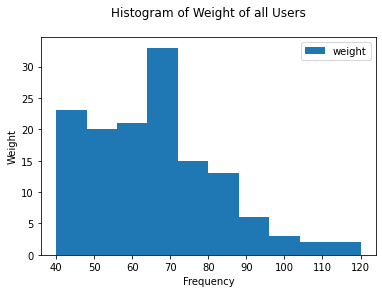

In [36]:
# plot the Histogram of Weight of all Users\
df7.weight.plot.hist();
beautify_plot(f'Histogram of Weight of all Users\n', 'Frequency', 'Weight');

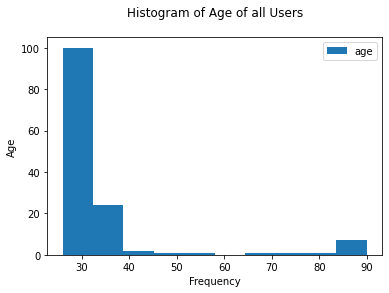

In [37]:
# plot the Histogram of Age of all Users\
df7.age.plot.hist();
beautify_plot(f'Histogram of Age of all Users\n', 'Frequency', 'Age');

In [38]:
df7_final = pd.concat([pd.get_dummies(df7.drop(['userID', 'age', 'weight'], axis=1)), df7[['userID', 'age', 'weight']]], axis=1)\
              .groupby('userID').sum().reset_index() # one hot encode the features

# add the dataframe to the training and testing list
df_master_train.append(df7_final) 
df_master_test.append(df7_final)

## 2. Creating Training Data

In [39]:
# reduce and create a single dataframe
df_train = reduce(lambda x,y: x.merge(y, 'left'), df_master_train)
assert(df_train.shape[0] == df_master_train[0].shape[0])

In [40]:
# apply the imputation rules
print(f'# NaNs :: {reduce(lambda x,y: x+y, df_train.isna().sum())}')
for i in imputation_rules.keys():
    if type(imputation_rules[i]) == dict: # if it is fillna
        for j in imputation_rules[i].keys():
            if j == 'fillna':
                df_train[i] = df_train[i].fillna(imputation_rules[i][j])
    else: # if it is mode
        df_train[i] = df_train[i].fillna(df_train[i].mode()[0])
print(f'# NaNs after applying Rules :: {reduce(lambda x,y: x+y, df_train.isna().sum())}')

# NaNs :: 4562
# NaNs after applying Rules :: 0


## 3. Creating Test and Validation Data

In [41]:
# create exhaustive list of places and users which appear in the files
places = set(reduce(lambda x,y: x[['placeID']].append(y[['placeID']]), df_master_test[:4]).placeID)
users = set(reduce(lambda x,y: x[['userID']].append(y[['userID']]), df_master_test[4:]).userID)
df_test = pd.DataFrame(list(product(places, users)), columns=['placeID', 'userID'])

# take only those which are not rated
df_test = df_test.merge(df_train[['placeID', 'userID']], 'outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
ast_shape = df_test.shape

# get the profiles for this master data
df_test = [df_test] + df_master_test
df_test = reduce(lambda x,y: x.merge(y, 'left'), df_test)

assert(df_test.shape[0] == ast_shape[0])

In [42]:
# apply the imputation rules
print(f'# NaNs :: {reduce(lambda x,y: x+y, df_test.isna().sum())}')
for i in imputation_rules:
    if type(imputation_rules[i]) == dict: # if fillna
        for j in imputation_rules[i].keys():
            if j == 'fillna':
                df_test[i] = df_test[i].fillna(imputation_rules[i][j])
    else: # if mode
        df_test[i] = df_test[i].fillna(df_test[i].mode()[0])
print(f'# NaNs after applying Rules :: {reduce(lambda x,y: x+y, df_test.isna().sum())}')

# NaNs :: 1120818
# NaNs after applying Rules :: 0


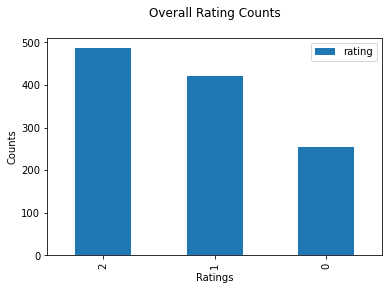

In [43]:
# plot the Overall Rating Counts
df_train.rating.value_counts().plot.bar()
beautify_plot('Overall Rating Counts\n', 'Ratings', 'Counts');

We see no imbalance in the dataset or presence of outliers in this case. We need to convert the ratings into a continuous value. We will add some noise (0-1 in real line) to the rating and do a log transform.

In [44]:
# create the validation training and test data
to_drop = ['rating', 'service_rating', 'food_rating', 'userID', 'placeID']
X_train = df_train.drop(to_drop, axis=1).astype('int')
y_train = df_train.rating

X_vtrain, X_vtest, y_vtrain, y_vtest = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

y_vtrain_cont = np.log1p(y_vtrain+np.random.rand())
y_vtest_cont = np.log1p(y_vtest+np.random.rand())

## 4. Regression Models
### 4.1 Linear Regression Model

In [45]:
def percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)*0.50))

In [46]:
res = sm.OLS(y_vtrain_cont, X_vtrain).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     4.393
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           6.61e-28
Time:                        08:26:31   Log-Likelihood:                -5.8133
No. Observations:                 870   AIC:                             173.6
Df Residuals:                     789   BIC:                             559.9
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Rpayment_american_express           0.0676      0.029      2.322      0.020       0.010       0.125
Rpayment_bank_debit_cards           0.0833      0.044      1.900      0.058      -0.003       0.169
Rpayment_carte_blanche              0.0663      0.128      0.519      0.604      -0.184       0.317
Rpayment_cash                      -0.0307      0.040     -0.775      0.439      -0.109       0.047
Rpayment_checks                     0.1974      0.176      1.121      0.263      -0.148       0.543
Rpayment_diners_club            -9.659e-14   9.25e-14     -1.044      0.297   -2.78e-13     8.5e-14
Rpayment_discover                   0.3716      0.188      1.976      0.048       0.003       0.741
Rpayment_gift_certificates      -6.075e-14   4.98e-14     -1.221      0.223   -1.58e-13    3.69e-14
Rpayment_japan_credit_bureau    -2.651e-14    3.9e-14     -0.680      0.497   -1.03e-13       5e-14
Rpayment_mastercard_eurocard        0.0841      0.062      1.359      0.175      -0.037       0.206
Rpayment_visa                      -0.0681      0.062     -1.101      0.271      -0.190       0.053
Rcuisine_american                  -0.0687      0.065     -1.061      0.289      -0.196       0.058
Rcuisine_bar                       -0.0362      0.034     -1.063      0.288      -0.103       0.031
Rcuisine_cafe_coffee_shop           0.1135      0.092      1.236      0.217      -0.067       0.294
Rcuisine_dutch_belgian           7.857e-15   3.04e-14      0.259      0.796   -5.18e-14    6.75e-14
Rcuisine_french                 -5.091e-15   8.43e-15     -0.604      0.546   -2.16e-14    1.15e-14
Rcuisine_greek                   6.347e-14   5.85e-14      1.084      0.279   -5.14e-14    1.78e-13
Rcuisine_international              0.0503      0.075      0.675      0.500      -0.096       0.197
Rcuisine_italian                   -0.1090      0.068     -1.607      0.108      -0.242       0.024
Rcuisine_mexican                    0.0018      0.041      0.045      0.964      -0.078       0.082
Rcuisine_others                    -0.0028      0.030     -0.092      0.927      -0.062       0.056
Rcuisine_pizzeria                  -0.0253      0.047     -0.533      0.594      -0.118       0.068
mon_tue_wed_thu_fri                -0.0013      0.003     -0.414      0.679      -0.008       0.005
sat                                 0.0022      0.004      0.536      0.592      -0.006       0.010
sun                                 0.0007      0.002      0.299      0.765      -0.004       0.006
parking_lot_fee                  1.189e-15   9.15e-16      1.299      0.194   -6.07e-16    2.98e-15
parking_lot_none                    0.1372      0.029      4.799      0.000       0.081       0.193
parking_lot_public                  0.1359      0.034      4.005      0.000       0

In [47]:
y_train_pred = list(map(math.floor, np.e**res.predict(X_vtrain)))
print('Training Accuracy and Error')
print('---------------------------')
print(f'Accuracy :: {accuracy_score(y_vtrain, y_train_pred):.2f}\nError :: {percentage_error(y_vtrain, y_train_pred):.2f}')

Training Accuracy and Error
---------------------------
Accuracy :: 0.15
Error :: 0.60


In [48]:
print('Test Accuracy and Error')
print('------------------------')
y_pred = list(map(math.floor, np.e**res.predict(X_vtest)))
print(f'Accuracy :: {accuracy_score(y_vtest, y_pred):.2f}\nError :: {percentage_error(y_vtest, y_pred):.2f}')

Test Accuracy and Error
------------------------
Accuracy :: 0.20
Error :: 0.56


We can see that the linear model didn't have a very good adjusted R2. But it's still acceptable, given the sparse nature.

When the accuracy score when the scores were converted back to the classes, the manual % error indicates that in the misclassified ones, it on an average made a mistake of saying +-1 of the actual rating.

On the test data, the error is 0.55 which means that the model mostly made much mistake to give the ratings ~(+-1 of the actual rating)

### 4.2 Decision Tree Regression Model

In [49]:
dt_res = DecisionTreeRegressor().fit(X_vtrain, y_vtrain_cont)

In [50]:
y_train_pred = list(map(math.floor, np.e**dt_res.predict(X_vtrain)))
print('Training Accuracy and Error')
print('---------------------------')
print(f'Accuracy :: {accuracy_score(y_vtrain, y_train_pred):.2f}\nError :: {percentage_error(y_vtrain, y_train_pred):.2f}')

Training Accuracy and Error
---------------------------
Accuracy :: 0.00
Error :: 0.51


In [51]:
print('Test Accuracy and Error')
print('------------------------')
y_pred = list(map(math.floor, np.e**dt_res.predict(X_vtest)))
print(f'Accuracy :: {accuracy_score(y_vtest, y_pred):.2f}\nError :: {percentage_error(y_vtest, y_pred):.2f}')

Test Accuracy and Error
------------------------
Accuracy :: 0.22
Error :: 0.51


## 5. Classification Models
### 5.1 Logistic regression

In [52]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=5000)
lr.fit(X_vtrain, y_vtrain)

LogisticRegression(max_iter=5000)

In [53]:
y_train_pred = list(map(math.floor, lr.predict(X_vtrain)))
print('Training Accuracy and Error')
print('---------------------------')
print(f'Accuracy :: {accuracy_score(y_vtrain, y_train_pred):.2f}\nError :: {percentage_error(y_vtrain, y_train_pred):.2f}')

Training Accuracy and Error
---------------------------
Accuracy :: 0.63
Error :: 0.23


In [54]:
print('Test Accuracy and Error')
print('------------------------')
y_pred = list(map(math.floor, lr.predict(X_vtest)))
print(f'Accuracy :: {accuracy_score(y_vtest, y_pred):.2f}\nError :: {percentage_error(y_vtest, y_pred):.2f}')

Test Accuracy and Error
------------------------
Accuracy :: 0.53
Error :: 0.29


### 5.2 Naive Bayes

In [55]:
nb = MultinomialNB()
nb.fit(X_vtrain, y_vtrain)

MultinomialNB()

In [56]:
y_train_pred = list(map(math.floor, nb.predict(X_vtrain)))
print('Training Accuracy and Error')
print('---------------------------')
print(f'Accuracy :: {accuracy_score(y_vtrain, y_train_pred):.2f}\nError :: {percentage_error(y_vtrain, y_train_pred):.2f}')

Training Accuracy and Error
---------------------------
Accuracy :: 0.48
Error :: 0.31


In [57]:
print('Test Accuracy and Error')
print('------------------------')
y_pred = list(map(math.floor, nb.predict(X_vtest)))
print(f'Accuracy :: {accuracy_score(y_vtest, y_pred):.2f}\nError :: {percentage_error(y_vtest, y_pred):.2f}')

Test Accuracy and Error
------------------------
Accuracy :: 0.52
Error :: 0.29


### 5.3 Random Forest

In [58]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_vtrain, y_vtrain)

RandomForestClassifier(n_estimators=50)

In [59]:
y_train_pred = list(map(math.floor, rf.predict(X_vtrain)))
print('Training Accuracy and Error')
print('---------------------------')
print(f'Accuracy :: {accuracy_score(y_vtrain, y_train_pred):.2f}\nError :: {percentage_error(y_vtrain, y_train_pred):.2f}')

Training Accuracy and Error
---------------------------
Accuracy :: 0.98
Error :: 0.01


In [60]:
print('Test Accuracy and Error')
print('------------------------')
y_pred = list(map(math.floor, rf.predict(X_vtest)))
print(f'Accuracy :: {accuracy_score(y_vtest, y_pred):.2f}\nError :: {percentage_error(y_vtest, y_pred):.2f}')

Test Accuracy and Error
------------------------
Accuracy :: 0.58
Error :: 0.25


### 5.4 SVM

In [61]:
svc = SVC(gamma='auto')
svc.fit(X_vtrain, y_vtrain)

SVC(gamma='auto')

In [62]:
y_train_pred = list(map(math.floor, svc.predict(X_vtrain)))
print('Training Accuracy and Error')
print('---------------------------')
print(f'Accuracy :: {accuracy_score(y_vtrain, y_train_pred):.2f}\nError :: {percentage_error(y_vtrain, y_train_pred):.2f}')

Training Accuracy and Error
---------------------------
Accuracy :: 0.63
Error :: 0.23


In [63]:
print('Test Accuracy and Error')
print('------------------------')
y_pred = list(map(math.floor, svc.predict(X_vtest)))
print(f'Accuracy :: {accuracy_score(y_vtest, y_pred):.2f}\nError :: {percentage_error(y_vtest, y_pred):.2f}')

Test Accuracy and Error
------------------------
Accuracy :: 0.46
Error :: 0.32


## 6. Comparison of the Models

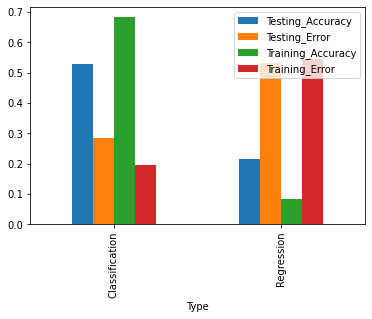

In [64]:
# store the metrics
evaluataion = {
     'Model': {0: 'Linear Regression',
               1: 'Decision Tree Regressor',
               2: 'Logistic Regression',
               3: 'Naive Bayes',
               4: 'Random Forest',
               5: 'SVM'},
     'Testing_Accuracy': {0: 0.21, 1: 0.22, 2: 0.53, 3: 0.52, 4: 0.6, 5: 0.46},
     'Testing_Error': {0: 0.55, 1: 0.51, 2: 0.29, 3: 0.29, 4: 0.24, 5: 0.32},
     'Training_Accuracy': {0: 0.17, 1: 0.0, 2: 0.63, 3: 0.48, 4: 0.99, 5: 0.63},
     'Training_Error': {0: 0.58, 1: 0.51, 2: 0.23, 3: 0.31, 4: 0.01, 5: 0.23},
     'Type': {0: 'Regression',
              1: 'Regression',
              2: 'Classification',
              3: 'Classification',
              4: 'Classification',
              5: 'Classification'}}
evaluataion = pd.DataFrame(evaluataion)
evaluataion.groupby('Type').mean().plot.bar();

We can see that the Testing Error went down for the classification models on an average by 50% and hence, we would proceed with the classification models.

In [65]:
evaluataion.query('Type=="Classification"')

,Model,Testing_Accuracy,Testing_Error,Training_Accuracy,Training_Error,Type
2,Logistic Regression,0.53,0.29,0.63,0.23,Classification
3,Naive Bayes,0.52,0.29,0.48,0.31,Classification
4,Random Forest,0.60,0.24,0.99,0.01,Classification
5,SVM,0.46,0.32,0.63,0.23,Classification


## 7. Predictions and Recommendation

In [66]:
# make the recommendations
y_test = pd.DataFrame(nb.predict(df_test.drop(['placeID', 'userID'], axis=1)), columns=['predicted_rating'])
df_recommend = pd.concat([df_test[['placeID', 'userID']], y_test], axis=1) # create exhaustive list

# get the top n recommendations and save it in a file
n = 3
df_recommend = df_recommend.sort_values(['userID', 'predicted_rating'], ascending=False).groupby('userID').head(n)
df_recommend.to_csv('final_recommendations.csv', index=False)